In [1]:
import numpy as np
import pandas as pd

import json
import itertools
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Pull Spotify Data

In [2]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [3]:
# Pull data
TRACK_DATA_PATH = "data/tracks_5kalbums.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 11841 songs from data/tracks_5kalbums.json
First ten songs: [['000InFFKfurNhrCj7yfMdM', 'Park Bench People', 1], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 70], ['00518PumkDdn560MsfLofT', 'The Fuss', 46], ['005FoVr63RI753jsNjfLax', 'Black Panther', 31], ['009Mof2o4aS1P2l3FbaEpa', 'Quetzal', 30], ['009TjPzPuetzFiJNnBEVrV', 'Used and Abused', 51], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 68], ['00KiXBZT9vf1XhcqkFrzug', 'Downward', 46], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 69], ['00Le8soPbjYT0TxmXflHmi', 'A God Who Sees (Me & Lucy)', 39]]


## Data Exploration

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


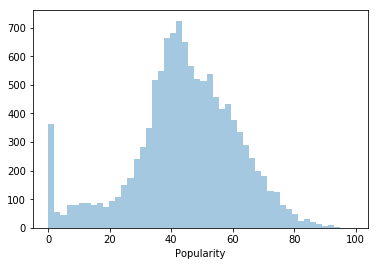

In [4]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [5]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['0s3nnoMeVWz3989MkNQiRf', 'Lucid Dreams', 93],
 ['14JzyD6FlBD5z0wV5P07YI', "when the party's over", 93],
 ['1xzBco0xcoJEDXktl7Jxrr', 'Mo Bamba', 93],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 93],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 94],
 ['1A6OTy97kk0mMdm78rHsm8',
  'Sunflower - Spider-Man: Into the Spider-Verse',
  95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 95],
 ['7l3E7lcozEodtVsSTCkcaA', 'ZEZE (feat. Travis Scott & Offset)', 95],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  99]]

## Feature Extraction

In [6]:
# audio_features provides high-level Echo Nest features
sp.audio_features(songs[0][0])

[{'acousticness': 0.367,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/000InFFKfurNhrCj7yfMdM',
  'danceability': 0.658,
  'duration_ms': 315707,
  'energy': 0.379,
  'id': '000InFFKfurNhrCj7yfMdM',
  'instrumentalness': 0.000493,
  'key': 5,
  'liveness': 0.0728,
  'loudness': -11.763,
  'mode': 0,
  'speechiness': 0.0444,
  'tempo': 135.991,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/000InFFKfurNhrCj7yfMdM',
  'type': 'audio_features',
  'uri': 'spotify:track:000InFFKfurNhrCj7yfMdM',
  'valence': 0.81}]

In [7]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [8]:
feats = features(songs)
feats[100]

{'acousticness': 0.00383,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'danceability': 0.964,
 'duration_ms': 263933,
 'energy': 0.502,
 'id': '04yv0dtqVm9u745efIuxbZ',
 'instrumentalness': 0,
 'key': 0,
 'liveness': 0.0874,
 'loudness': -7.604,
 'mode': 1,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69,
 'speechiness': 0.191,
 'tempo': 127.993,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'type': 'audio_features',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'valence': 0.551}

#### Artist Feature Extraction

In [9]:
def get_trackid_artistid_dict(tracks):
    """
    Given list of track_ids
    returns dictionary from all track_ids to artist IDs
    """
    track_artist_dict = {}
    for i in range(0, len(tracks), 50):
        track_ids = tracks[i : i + 50]
        track_infos = sp.tracks(track_ids)["tracks"]
        assert len(track_ids) == len(track_infos)
        for track_id, info in zip(track_ids, track_infos):
            if not info:
                continue # song not found in Spotify
            track_artist_dict[track_id] = info["artists"][0]["id"]
        if len(track_artist_dict) % 1000 == 0:
            print("Stored {} artist IDs".format(len(track_artist_dict)))
            print(list(track_artist_dict.items())[-1:])
    print("Stored {} artist IDs".format(len(track_artist_dict)))
    return track_artist_dict

In [10]:
def get_artistid_to_features_dict(artist_ids):
    """
    Given iterable of artist_ids, returns a map from artist_id to feature_dict for each artist
    e.g. {"093sDFBR924": {"followers" : 1038, "genres": ["pop", "rock"]},
            "RV3910FWS": {"followers" : 31001, "genres": ["country"]}
    """
    feature_dict = {}
    unique_ids = list(set(artist_ids))
    for i in range(0, len(unique_ids), 50):
        artist_ids_chunk = unique_ids[i : i + 50]
        artist_infos = sp.artists(artist_ids_chunk)["artists"]
        assert len(artist_infos) == len(artist_ids_chunk)
        for artist_id, info in zip(artist_ids_chunk, artist_infos):
            if not info:
                continue
            feature_dict[artist_id] = {
                "artist_followers": info["followers"]["total"],
                "artist_popularity": info["popularity"],
                "artist_genres": info["genres"]
            }
        if len(feature_dict) % 1000 == 0:
            print("Stored {} artists' features".format(len(feature_dict)))
            print(list(feature_dict.items())[-1:])
    print("Stored {} artists' features".format(len(feature_dict)))
    return feature_dict

In [11]:
def add_artist_features(features_list):
    """
    Takes in a list of feature dictionaries, adds artist features
    Requires that track_id be a feature in each song
    """
    # TODO: Could speed up by adding parameters to read or write these dictionaries from files
    features_list = feats
    track_ids = [f["id"] for f in features_list]
    print("BUILDING TRACK ID -> ARTIST ID DICTIONARY")
    track_artist_dict = get_trackid_artistid_dict(track_ids) 
    artist_ids = list(set(track_artist_dict.values()))
    print("BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY")
    artist_feature_dict = get_artistid_to_features_dict(artist_ids)
    features_list = [f for f in features_list if f["id"] in track_artist_dict and track_artist_dict[f["id"]] in artist_feature_dict]
    for features in features_list:
        track_artist_features = artist_feature_dict[track_artist_dict[features["id"]]]
        features.update(track_artist_features)
    return features_list

In [12]:
feats = add_artist_features(feats)
feats[100]

BUILDING TRACK ID -> ARTIST ID DICTIONARY
Stored 1000 artist IDs
[('0hpVsKtKOhxY3QYtzat4YI', '25KNo5GDS6ZpLkjasaecA3')]
Stored 2000 artist IDs
[('1M732H32aWAHYGDBOFU2br', '2J0JN7EFN10G1Tty6hX0AN')]
Stored 3000 artist IDs
[('21QNvLDoeQS1G4FxRvZNBL', '0Y4inQK6OespitzD6ijMwb')]
Stored 4000 artist IDs
[('2gafFAtDIGgDQLiEpRokIx', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 5000 artist IDs
[('3LjvFUqQi5LoqaRK6CLwMk', '1dfeR4HaWDbWqFHLkxsg1d')]
Stored 6000 artist IDs
[('3y6GnNl3mK2Rqw5N6vA5Se', '74gcBzlQza1bSfob90yRhR')]
Stored 7000 artist IDs
[('4eLHWCv6pLrxvpKomdGx5w', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 8000 artist IDs
[('5J3Rb54DgCiN1OLIuKu1sL', '2vGA5qCDLZGW6exRQgKfLL')]
Stored 9000 artist IDs
[('60mz2UG8P6BTE0sSl1MNMJ', '1vaOLxWPpsv5LVsSHBy9tF')]
Stored 10000 artist IDs
[('6gC1f3S8JdxFHcOTlz1sLC', '6JaSyvyg28SHC0Of8YE6M9')]
Stored 11000 artist IDs
[('7InCc97CcXdcFzla1zPWJS', '5aBxFPaaGk9204ssHUvXWN')]
Stored 11741 artist IDs
BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY
Stored 1000 artists' feat

{'acousticness': 0.00383,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'artist_followers': 3533695,
 'artist_genres': ['atl hip hop',
  'gangster rap',
  'hip hop',
  'pop',
  'pop rap',
  'rap',
  'trap music'],
 'artist_popularity': 88,
 'danceability': 0.964,
 'duration_ms': 263933,
 'energy': 0.502,
 'id': '04yv0dtqVm9u745efIuxbZ',
 'instrumentalness': 0,
 'key': 0,
 'liveness': 0.0874,
 'loudness': -7.604,
 'mode': 1,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69,
 'speechiness': 0.191,
 'tempo': 127.993,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'type': 'audio_features',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'valence': 0.551}

In [13]:
def format_genre_features(features_list, feature_cutoff=0.01):
    """
    Returns (updated features, feature_genres)
    """
    genre_counts = Counter(g for f in features_list for g in f["artist_genres"])
    print("Number of genres: {}".format(len(genre_counts)))
    print("Most popular genres: {}".format(genre_counts.most_common(10)))
    feature_cutoff_num = feature_cutoff * len(features_list)
    feature_genres = set([g for g in genre_counts if genre_counts[g] >= feature_cutoff_num])
    print("Number of featurized genres: {}".format(len(feature_genres)))
    for feat in features_list:
        for genre in feature_genres:
            feat["genre_" + genre] = 1 if genre in feat["artist_genres"] else 0
    feature_genres = ["genre_" + g + "" for g in feature_genres]
    return features_list, feature_genres

In [14]:
feats, feature_genres = format_genre_features(feats)

Number of genres: 557
Most popular genres: [('pop', 1967), ('rap', 1748), ('trap music', 1527), ('pop rap', 1296), ('hip hop', 1125), ('dance pop', 952), ('southern hip hop', 937), ('underground hip hop', 834), ('vapor trap', 739), ('indie r&b', 727)]
Number of featurized genres: 96


In [15]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
4448,0.21400,https://api.spotify.com/v1/audio-analysis/2z6N...,2075389,[indie rock],75,0.574,214760,0.650,0,0,...,0,In Cold Blood (feat. Kontra K) - Kontra K Version,44,0.0997,71.291,4,https://api.spotify.com/v1/tracks/2z6NNo1IvswJ...,audio_features,spotify:track:2z6NNo1IvswJk8gHCghzOI,0.530
3629,0.04980,https://api.spotify.com/v1/audio-analysis/2QcS...,21132581,"[dance pop, pop, post-teen pop]",97,0.748,170933,0.777,0,0,...,1,Santa Baby,24,0.1360,95.986,4,https://api.spotify.com/v1/tracks/2QcSkmxMs4MX...,audio_features,spotify:track:2QcSkmxMs4MX2XdQZlqjcx,0.769
2840,0.20500,https://api.spotify.com/v1/audio-analysis/1udN...,159129,[saskatchewan indie],60,0.532,200347,0.628,0,0,...,0,Banjo Odyssey,48,0.0403,92.593,4,https://api.spotify.com/v1/tracks/1udNc7oRKsxt...,audio_features,spotify:track:1udNc7oRKsxtPH5z1J0e3P,0.508
3374,0.94300,https://api.spotify.com/v1/audio-analysis/2FWm...,560014,"[norwegian pop, pop]",68,0.212,249107,0.151,0,0,...,0,It Happened Quiet,47,0.0352,72.529,4,https://api.spotify.com/v1/tracks/2FWm0B9aX0k5...,audio_features,spotify:track:2FWm0B9aX0k5FZIc4mOn3W,0.186
4021,0.00369,https://api.spotify.com/v1/audio-analysis/2hVt...,461865,"[conscious hip hop, dirty south rap, gangster ...",68,0.836,258520,0.779,0,0,...,1,Hussle & Motivate,57,0.0519,119.908,4,https://api.spotify.com/v1/tracks/2hVtGnJeHOo0...,audio_features,spotify:track:2hVtGnJeHOo0EqjzYXNFg5,0.555


In [16]:
data.loc[data['popularity'] >= 95]

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
1693,0.55100,https://api.spotify.com/v1/audio-analysis/1A6O...,9085155,"[pop, rap]",96,0.753,158053,0.498,0,0,...,1,Sunflower - Spider-Man: Into the Spider-Verse,95,0.0504,89.950,4,https://api.spotify.com/v1/tracks/1A6OTy97kk0m...,audio_features,spotify:track:1A6OTy97kk0mMdm78rHsm8,0.927
11385,0.05150,https://api.spotify.com/v1/audio-analysis/7l3E...,3929823,"[miami hip hop, pop, pop rap, rap, trap music]",91,0.861,228654,0.637,0,0,...,0,ZEZE (feat. Travis Scott & Offset),95,0.2400,98.044,4,https://api.spotify.com/v1/tracks/7l3E7lcozEod...,audio_features,spotify:track:7l3E7lcozEodtVsSTCkcaA,0.474
7452,0.15300,https://api.spotify.com/v1/audio-analysis/4w8n...,3590713,"[dance pop, edm, electronic trap, pop, tropica...",89,0.841,212500,0.798,0,0,...,0,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",99,0.2290,95.948,4,https://api.spotify.com/v1/tracks/4w8niZpiMy6q...,audio_features,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591
4392,0.00513,https://api.spotify.com/v1/audio-analysis/2xLM...,3861787,"[pop, pop rap, rap]",96,0.834,312820,0.730,0,0,...,1,SICKO MODE,95,0.2220,155.008,4,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,audio_features,spotify:track:2xLMifQCjDGFmkHkpNLD9h,0.446
8713,0.29700,https://api.spotify.com/v1/audio-analysis/5p7u...,4448531,"[dance pop, electropop, etherpop, indie poptim...",91,0.752,201661,0.488,0,0,...,1,Without Me,96,0.0705,136.041,4,https://api.spotify.com/v1/tracks/5p7ujcrUXASC...,audio_features,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533


In [17]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence", "artist_followers"] + feature_genres

In [51]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 8217, Dev size: 1762, Test size: 1762


## Baseline (Linear Regression)

In [52]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 202.65580313284036
Variance Score: -1.376608977400382


In [21]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': 1.2595139057651572, 'danceability': 7.440555117382553, 'energy': -1.1447716377440391, 'loudness': 0.5636853303683971, 'speechiness': -7.6894305061392, 'tempo': 0.003925476150008548, 'valence': -3.745104794793855, 'artist_followers': 1.4248472630079241e-06, 'genre_pop': 2.7968520203915435, 'genre_vapor soul': -2.9975981323077296, 'genre_viral pop': -2.503344803978951, 'genre_indie pop': -1.460767716360638, 'genre_canadian hip hop': -0.8910308772271103, 'genre_christian alternative rock': 2.417060389830574, 'genre_video game music': 1.7581108866533983, 'genre_canadian contemporary country': 0.08865340404681588, 'genre_rock': 1.1555697055524863, 'genre_alternative metal': 1.5839924437632102, 'genre_contemporary country': -0.31480789993507663, 'genre_scorecore': -3.92793282221722, 'genre_pop rock': -1.5677760705335801, 'genre_edm': -3.3009354939728937, 'genre_metropopolis': -6.195258303313185, 'genre_indie r&b': 3.8968986113178863, 'genre_anthem worship

## SVM 

In [22]:
svr = SVR(C=10)
svr.fit(x_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 161.7954904281748
SVM Variance Score: -0.8448636453253131


## Random Forest

In [54]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [55]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 137.42620291989115
Random Forest Variance Score: 0.04035024741319104


In [30]:
dev_data = data[data.index.isin(x_dev.index)].reindex(x_dev.index)
#dev_data #.sort_values(by=['popularity'])
dev_data

,acousticness,analysis_url,artist_followers,artist_genres,artist_popularity,danceability,duration_ms,energy,genre_album rock,genre_alternative dance,...,mode,name,popularity,speechiness,tempo,time_signature,track_href,type,uri,valence
1006,0.020100,https://api.spotify.com/v1/audio-analysis/0i1z...,291152,[children's music],70,0.629,182000,0.71700,0,0,...,1,Whatever It Takes,44,0.0341,134.964,4,https://api.spotify.com/v1/tracks/0i1zYnneo8Mh...,audio_features,spotify:track:0i1zYnneo8MhJH8M3itrC8,0.6400
11690,0.025300,https://api.spotify.com/v1/audio-analysis/7xUp...,111818,"[battle rap, dirty south rap, gangster rap, ha...",75,0.604,238454,0.89600,0,0,...,1,SWIZZMONTANA,56,0.1620,93.066,4,https://api.spotify.com/v1/tracks/7xUpDu4AXrj4...,audio_features,spotify:track:7xUpDu4AXrj4HbOOhieaM5,0.8810
6750,0.169000,https://api.spotify.com/v1/audio-analysis/4UYQ...,296725,"[emo rap, miami hip hop, underground hip hop, ...",70,0.767,230501,0.85400,0,0,...,0,Void,61,0.0675,109.943,4,https://api.spotify.com/v1/tracks/4UYQHTgOlSda...,audio_features,spotify:track:4UYQHTgOlSdaQWfUTAjpop,0.5190
900,0.418000,https://api.spotify.com/v1/audio-analysis/0ddh...,1240886,"[atl hip hop, hip hop, indie r&b, pop, pop rap...",85,0.559,246088,0.30100,0,0,...,0,East Atlanta Love Letter (feat. Future),37,0.0837,62.235,4,https://api.spotify.com/v1/tracks/0ddh2t6uKwp7...,audio_features,spotify:track:0ddh2t6uKwp7vY8MGuCSyG,0.1860
244,0.028100,https://api.spotify.com/v1/audio-analysis/0BYn...,129218,"[christian hip hop, christian trap]",57,0.561,227993,0.85200,0,0,...,1,Gotta Live,57,0.1040,146.929,4,https://api.spotify.com/v1/tracks/0BYnII68HNa5...,audio_features,spotify:track:0BYnII68HNa5VjeQru6Zrf,0.4920
6508,0.035300,https://api.spotify.com/v1/audio-analysis/4Jje...,1069323,"[canadian hip hop, pop, pop rap, rap, southern...",82,0.925,202213,0.73600,0,0,...,1,EAT (feat. Gunna),59,0.1320,147.013,4,https://api.spotify.com/v1/tracks/4JjerUTEnRGo...,audio_features,spotify:track:4JjerUTEnRGocSRT74VsaH,0.4930
9194,0.919000,https://api.spotify.com/v1/audio-analysis/68vX...,14193,"[bedroom soul, indie r&b]",64,0.616,191000,0.20400,0,0,...,0,Honesty,57,0.0331,79.826,4,https://api.spotify.com/v1/tracks/68vX3NqqjR7L...,audio_features,spotify:track:68vX3NqqjR7LVbyBd2EHF7,0.4190
11563,0.018700,https://api.spotify.com/v1/audio-analysis/7saY...,43099,"[alternative emo, anthem emo, aussie emo, mode...",54,0.618,196747,0.76200,0,0,...,1,Broken,40,0.0448,134.963,4,https://api.spotify.com/v1/tracks/7saYtIBl9MUx...,audio_features,spotify:track:7saYtIBl9MUxf5MbZR3TfN,0.4630
5804,0.325000,https://api.spotify.com/v1/audio-analysis/3r60...,193864,"[regional mexican, regional mexican pop]",67,0.538,223295,0.84700,0,0,...,1,El De Las Calles,44,0.0571,167.095,3,https://api.spotify.com/v1/tracks/3r60uCBpTVDQ...,audio_features,spotify:track:3r60uCBpTVDQyh8MBBUUtl,0.8380
6187,0.000034,https://api.spotify.com/v1/audio-analysis/45b1...,74873,"[australian indie, indie psych-rock, indietron...",55,0.358,210419,0.76100,0,0,...,1,Dominos,43,0.0445,134.039,4,https://api.spotify.com/v1/tracks/45b1APHcJSKy...,audio_features,spotify:track:45b1APHcJSKyQWysDz3L8Q,0.5130


In [31]:
dev_data["pred_popularity"] = test_preds
dev_data[["name", "popularity", "pred_popularity"]].sort_values(by=['popularity'])

,name,popularity,pred_popularity
6528,Wit The Shits (W.T.S) [feat. Melii],0,39.634834
9930,Everything Turns to Shit,0,12.274041
1050,Oodles O' Noodles Babies,0,38.924927
8157,Intro,0,40.119102
4306,Uptown Vibes (feat. Fabolous & Anuel AA),0,40.055943
4603,Tic Tac Toe (feat. Kodak Black),0,40.880230
11726,No Matter What,0,15.640071
2447,"Magnificat in E-Flat Major, BWV 243a: Gloria i...",0,13.759121
7617,Love Bites - Remastered 2017,0,16.071732
10807,When Love And Hate Collide,0,16.770765


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


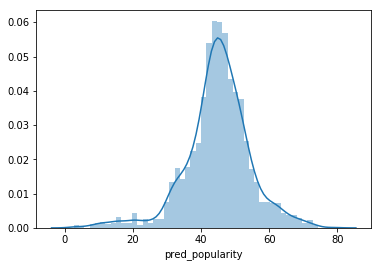

In [32]:
# Plot popularity distribution
sns.distplot(dev_data["pred_popularity"])

## Gradient Boosting Regressor

In [26]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

In [27]:
test_preds = gbr.predict(x_dev)
print("Gradient Boosting Regressor Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Gradient Boosting Regressor Variance Score: {}".format(r2_score(test_preds, y_dev)))

Gradient Boosting Regressor Mean Squared Error: 165.44375667054175
Gradient Boosting Regressor Variance Score: -1.023501630125069


In [115]:
## XG Boosting Regressor (Hyperparamterized Gradient Boosting)

In [37]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
import itertools

In [56]:
XGB = XGBRegressor(
    learning_rate=0.1,
    n_estimators=400,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=1)

XGB.fit(x_train, y_train)
test_preds = XGB.predict(x_dev)
accuracy = XGB.score(x_dev, y_dev)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("MSE: %.2f"
      % mean_squared_error(test_preds, y_dev))

Accuracy: 49.07%
MSE: 143.47


In [48]:
lr = [0.1, 0.3]
n_estimators = [300, 400]
max_depth = [3, 4]

gridsearch = []

for prod in itertools.product(lr, n_estimators, max_depth):
    gridsearch.append(prod)
gridsearch

[(0.1, 300, 3),
 (0.1, 300, 4),
 (0.1, 400, 3),
 (0.1, 400, 4),
 (0.3, 300, 3),
 (0.3, 300, 4),
 (0.3, 400, 3),
 (0.3, 400, 4)]

In [47]:
for hparams in gridsearch:
    lr, n_est, max_d = hparams
    print("Lr, num est, max depth: ", lr, n_est, max_d)
    XGB = XGBRegressor(
        learning_rate=lr,
        n_estimators=n_est,
        max_depth=max_d,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1)

    XGB.fit(x_train, y_train)
    test_preds = XGB.predict(x_dev)
    accuracy = XGB.score(x_dev, y_dev)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("MSE: %.2f"
          % mean_squared_error(test_preds, y_dev))

Lr, num est, max depth:  0.1 300 3
Accuracy: 44.93%
MSE: 146.50
Lr, num est, max depth:  0.1 300 4
Accuracy: 47.76%
MSE: 138.96
Lr, num est, max depth:  0.1 400 3
Accuracy: 45.72%
MSE: 144.39
Lr, num est, max depth:  0.1 400 4
Accuracy: 48.26%
MSE: 137.65
Lr, num est, max depth:  0.3 300 3
Accuracy: 46.92%
MSE: 141.20
Lr, num est, max depth:  0.3 300 4
Accuracy: 45.49%
MSE: 145.00
Lr, num est, max depth:  0.3 400 3
Accuracy: 47.51%
MSE: 139.62
Lr, num est, max depth:  0.3 400 4
Accuracy: 44.95%
MSE: 146.43
Lr, num est, max depth:  0.5 300 3
Accuracy: 41.40%
MSE: 155.89
Lr, num est, max depth:  0.5 300 4
Accuracy: 37.62%
MSE: 165.95
Lr, num est, max depth:  0.5 400 3
Accuracy: 40.49%
MSE: 158.30
Lr, num est, max depth:  0.5 400 4
Accuracy: 36.59%
MSE: 168.68


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

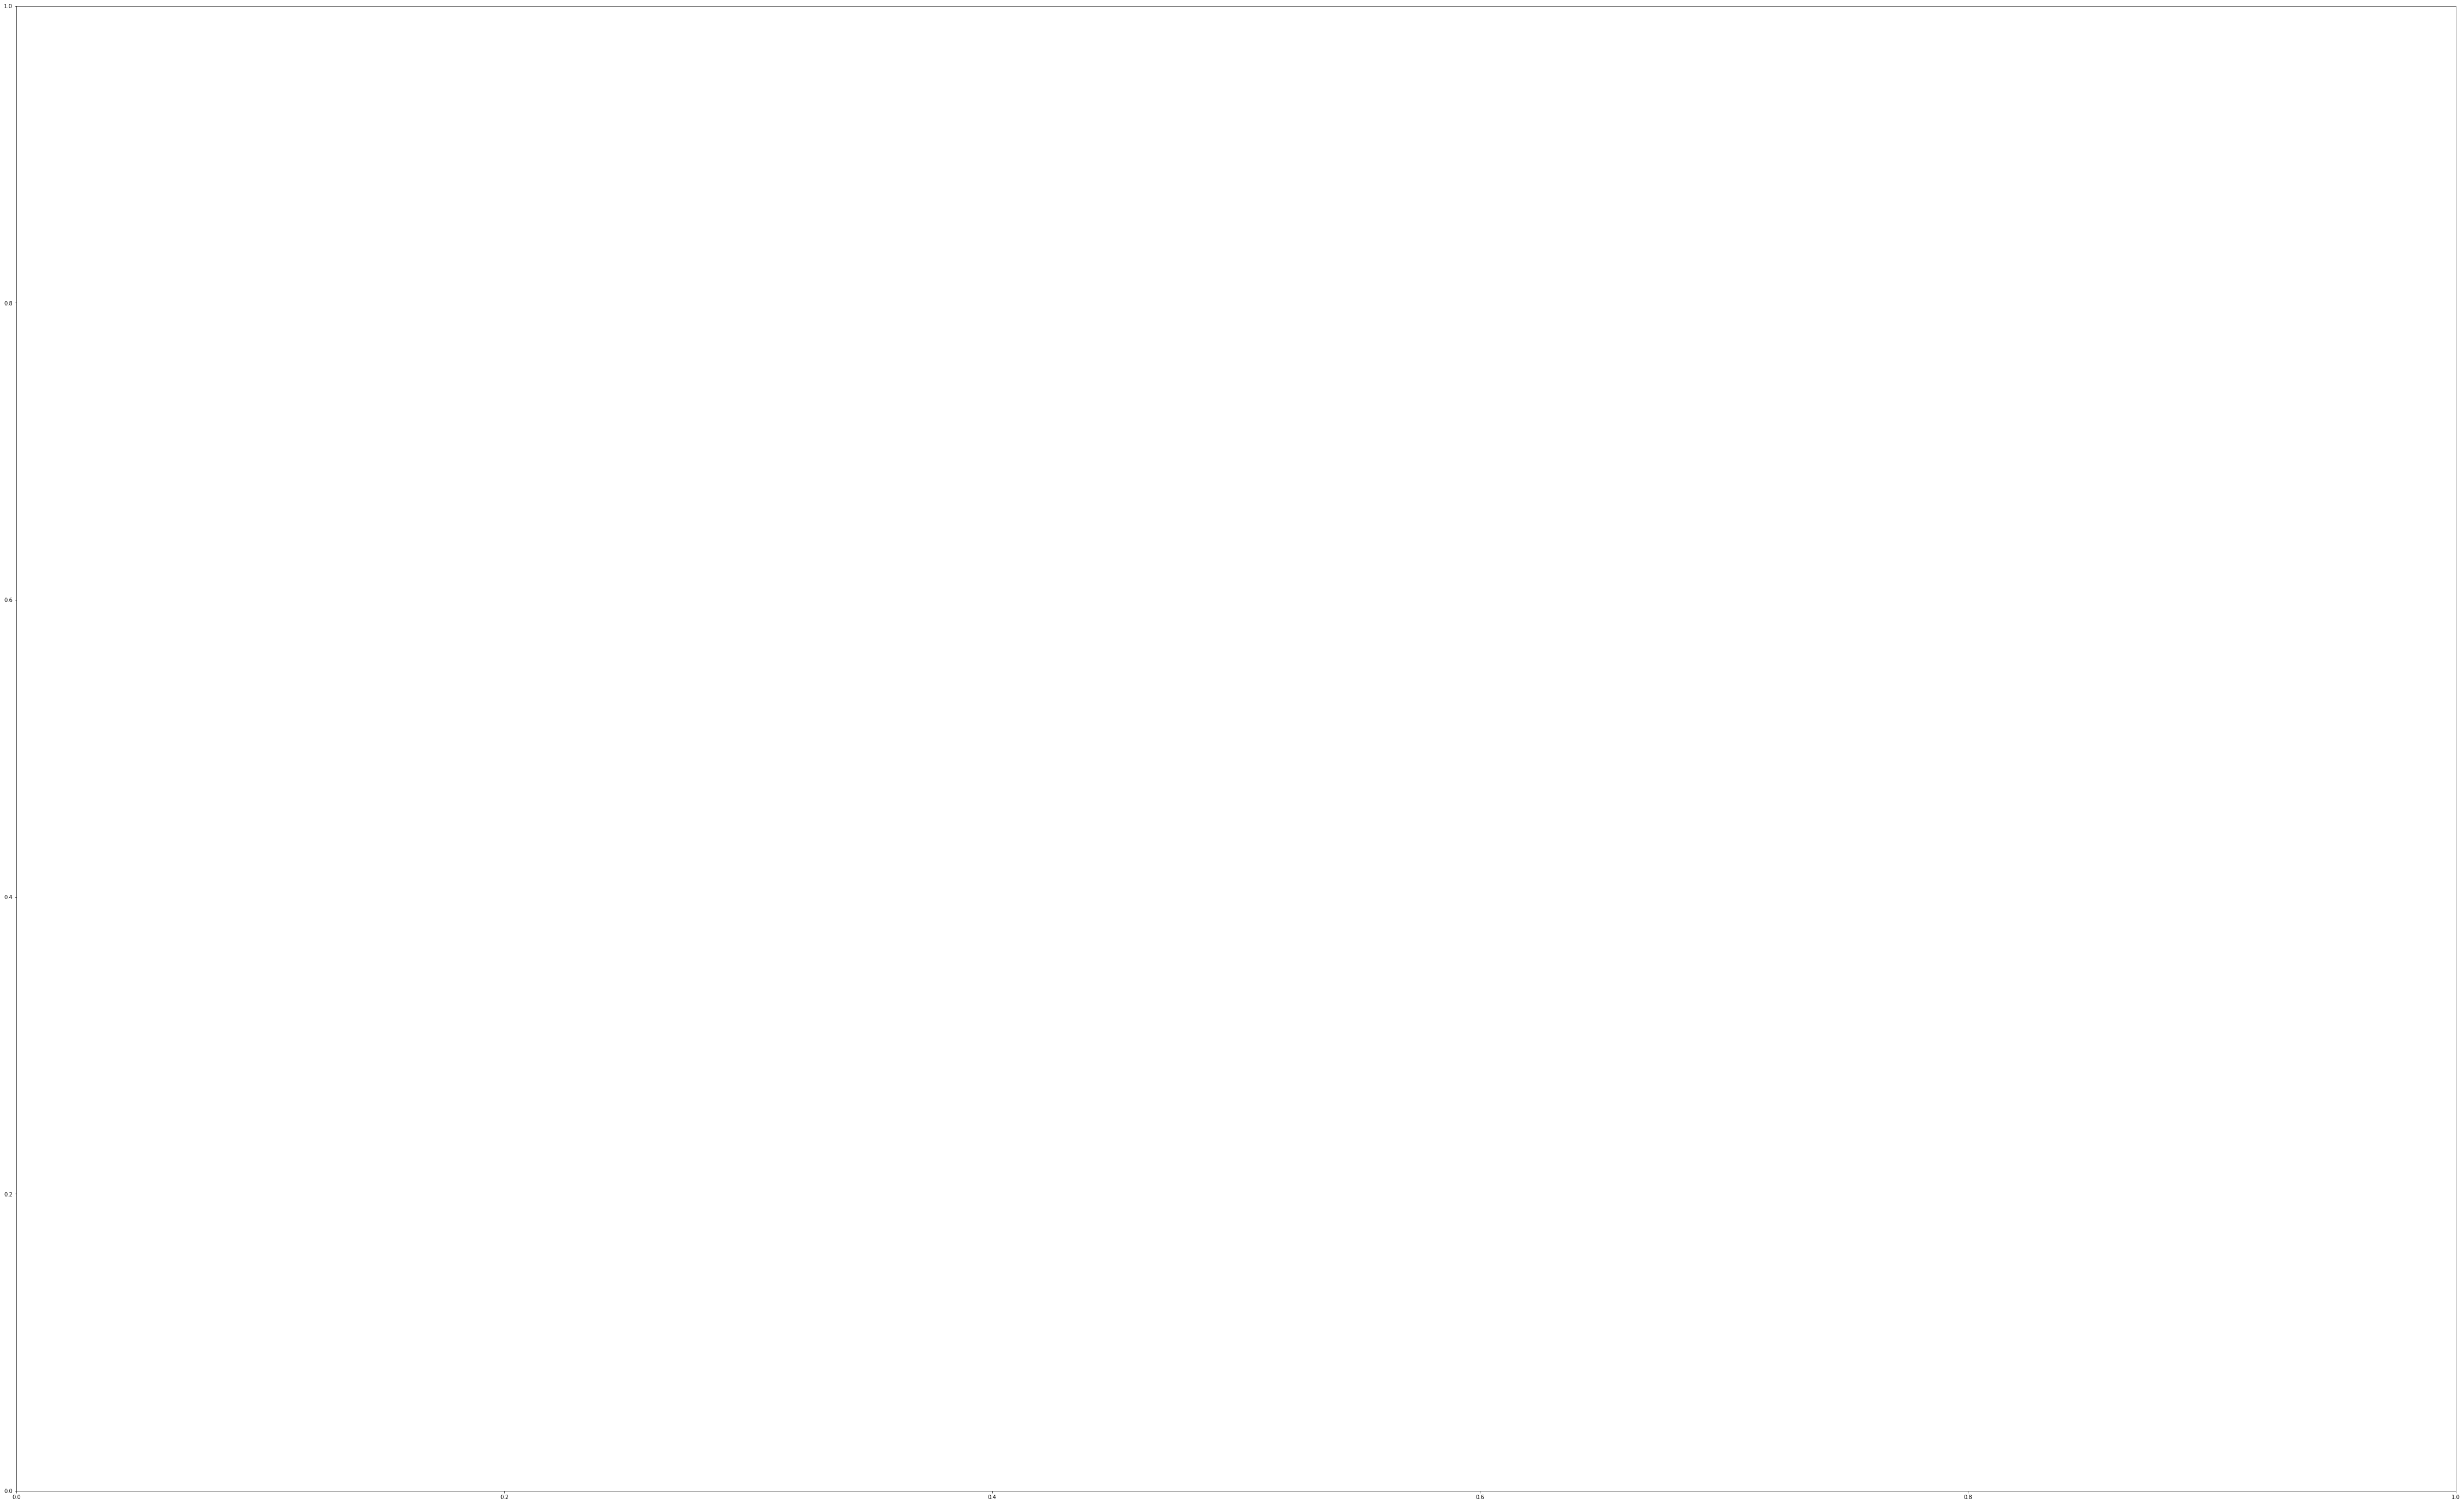

In [34]:
# Comment out to save memory

rcParams['figure.figsize'] = 80,50
plot_tree(XGB)
fig = plt.gcf()
fig.set_size_inches(50, 30)
fig.savefig('tree.eps')

In [ ]:
feat_imp = pd.Series(XGB.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar')
plt.xticks(size = 50)
plt.yticks(size = 60)
plt.suptitle('Feature Importances', fontsize=60)
plt.ylabel('Feature Importance Score', size = 60)
plt.savefig("FE.eps")